# Train LSTM model using Keras

In [1]:
import pandas as pd 
import numpy as np 
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

import matplotlib.pyplot as plt

from gensim.models import KeyedVectors

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/koalachelsea/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using TensorFlow backend.


In [2]:
# parameter
max_features = 5000 # the number of words to encode
maxlen = 100 # maximum size of each list

# Data Processing
## Loadfile
- Load csv file generated from data_clean.ipynb
- Combine positive and negative reviews together and assign labels
- Convert sentiment to numeric: index 1 is positive and 0 is negative

In [3]:
train_neg = pd.read_csv('data/train_neg.csv', index_col=None, encoding='utf-8')
train_pos = pd.read_csv('data/train_pos.csv', index_col=None, encoding='utf-8')
train = np.concatenate([train_neg, train_pos], axis=0)
train = pd.DataFrame(data=train, columns=["review", "sentiment"])
train

,review,sentiment
0,Working with one of the best Shakespeare sourc...,neg
1,"Well...tremors I, the original started off in ...",neg
2,Ouch! This one was a bit painful to sit throug...,neg
3,"I've seen some crappy movies in my life, but t...",neg
4,"""Carriers"" follows the exploits of two guys an...",neg
...,...,...
24995,About a year ago I finally gave up on American...,pos
24996,When I saw the elaborate DVD box for this and ...,pos
24997,"Last November, I had a chance to see this film...",pos
24998,Great movie -I loved it. Great editing and use...,pos


In [4]:
test_neg = pd.read_csv('data/test_neg.csv', index_col=None, encoding='utf-8')
test_pos = pd.read_csv('data/test_pos.csv', index_col=None, encoding='utf-8')
test = np.concatenate([test_neg, test_pos], axis=0)
test = pd.DataFrame(data=test, columns=["review", "sentiment"])
test

,review,sentiment
0,Alan Rickman & Emma Thompson give good perform...,neg
1,I have seen this movie and I did not care for ...,neg
2,"In Los Angeles, the alcoholic and lazy Hank Ch...",neg
3,"This film is bundled along with ""Gli fumavano ...",neg
4,I only comment on really very good films and o...,neg
...,...,...
24995,"This movie is certainly well-constructed, begi...",pos
24996,Nice to see a comedy for grown ups. Masterfull...,pos
24997,Jean Renoir's homage to the Paris of the late ...,pos
24998,What are the movies? I mean.. what are movies ...,pos


## Clean the text
- Remove special format
- Word tokenize
- Ignore stop words
- Stemming

In [5]:
def clean_text(text):
    # Remove url
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', ' ', str(text))
    
    # Remove hashtags
    # only removing the hash # sign from the word, we believe hashtags contains useful information
    text = re.sub(r'#', '', str(text))
    
    # replace consecutive non-ASCII characters with a space
    text = re.sub(r'[^\x00-\x7F]+', ' ', str(text))
    
    # Clean the text
    text = re.sub(r'<br />', ' ', str(text))
    return text

In [6]:
# clean the text
train['clean text'] = train['review'].map(lambda x: clean_text(x))
test['clean text'] = test['review'].map(lambda x: clean_text(x))

In [7]:
# tokenize the review
train['token'] = train['clean text'].apply(word_tokenize)\
.apply(lambda x: [item for item in x if item.isalpha()])
test['token'] = test['clean text'].apply(word_tokenize)\
.apply(lambda x: [item for item in x if item.isalpha()])

# clean the token by stopword removal and stemming
stemmer = SnowballStemmer("english", ignore_stopwords=True)

train['clean token'] = train['token'].apply(lambda x: [item for item in x if item not in stop_words])\
.apply(lambda x: [stemmer.stem(item) for item in x])
test['clean token'] = test['token'].apply(lambda x: [item for item in x if item not in stop_words])\
.apply(lambda x: [stemmer.stem(item) for item in x])

In [8]:
# return cleaned token as text back to dataframe
train['detoken'] = train['clean token'].apply(lambda x: TreebankWordDetokenizer().detokenize(x))
test['detoken'] = test['clean token'].apply(lambda x: TreebankWordDetokenizer().detokenize(x))

In [9]:
train

,review,sentiment,clean text,token,clean token,detoken
0,Working with one of the best Shakespeare sourc...,neg,Working with one of the best Shakespeare sourc...,"[Working, with, one, of, the, best, Shakespear...","[work, one, best, shakespear, sourc, film, man...",work one best shakespear sourc film manag cred...
1,"Well...tremors I, the original started off in ...",neg,"Well...tremors I, the original started off in ...","[Well, tremors, I, the, original, started, off...","[well, tremor, i, origin, start, found, movi, ...",well tremor i origin start found movi quit enj...
2,Ouch! This one was a bit painful to sit throug...,neg,Ouch! This one was a bit painful to sit throug...,"[Ouch, This, one, was, a, bit, painful, to, si...","[ouch, this, one, bit, pain, sit, it, cute, am...",ouch this one bit pain sit it cute amus premis...
3,"I've seen some crappy movies in my life, but t...",neg,"I've seen some crappy movies in my life, but t...","[I, seen, some, crappy, movies, in, my, life, ...","[i, seen, crappi, movi, life, one, must, among...",i seen crappi movi life one must among worst d...
4,"""Carriers"" follows the exploits of two guys an...",neg,"""Carriers"" follows the exploits of two guys an...","[Carriers, follows, the, exploits, of, two, gu...","[carrier, follow, exploit, two, guy, two, gal,...",carrier follow exploit two guy two gal stolen ...
...,...,...,...,...,...,...
24995,About a year ago I finally gave up on American...,pos,About a year ago I finally gave up on American...,"[About, a, year, ago, I, finally, gave, up, on...","[about, year, ago, i, final, gave, american, t...",about year ago i final gave american televis i...
24996,When I saw the elaborate DVD box for this and ...,pos,When I saw the elaborate DVD box for this and ...,"[When, I, saw, the, elaborate, DVD, box, for, ...","[when, i, saw, elabor, dvd, box, dread, red, q...",when i saw elabor dvd box dread red queen figu...
24997,"Last November, I had a chance to see this film...",pos,"Last November, I had a chance to see this film...","[Last, November, I, had, a, chance, to, see, t...","[last, novemb, i, chanc, see, film, reno, film...",last novemb i chanc see film reno film festiv ...
24998,Great movie -I loved it. Great editing and use...,pos,Great movie -I loved it. Great editing and use...,"[Great, movie, loved, it, Great, editing, and,...","[great, movi, love, great, edit, use, soundtra...",great movi love great edit use soundtrack capt...


In [10]:
# convert sentiment to numeric
train['sentiment'] = train['sentiment'].map({'pos': 1, 'neg': 0})
test['sentiment'] = test['sentiment'].map({'pos': 1, 'neg': 0})
y_train = train['sentiment']
y_test = test['sentiment']

## Preparing text for NLP
- Extract the actual texts from training set
- Tokenizer: create a word-to-index dictionary: each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key.
- fit_on_texts: create associations of words and numbers.
- texts_to_sequences: transforms each text in texts to a sequence of integers.

In [11]:
# get the actual texts from training set
X_train = train.detoken.values.astype(str)
X_test = test.detoken.values.astype(str)
# initialize the tokenizer with a 5000 word limit
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
# list of texts to turn to sequences.
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

- find the vocabulary size
- pad_sequences: make all sequences in a given standard length
    - for list with size greater than 100, it will be truncated to 100. 
    - for list with size less than 100, it will add 0 at the end of the list until it reaches the max length 100.

In [12]:
# adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
# padding
X_train_padded_sequence = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test_padded_sequence = pad_sequences(X_test, padding='post', maxlen=maxlen)

66605


# Embedding: word2vec
Word-embeddings are numerical vector representations for words. They allow us to reduce the dimensionality of the word-space from the length of the corpus vocabulary to a much shorter length.

In [13]:
# Load vectors directly from the file
# https://code.google.com/archive/p/word2vec/
word2vec = KeyedVectors.load_word2vec_format('model/GoogleNews-vectors-negative300.bin', binary=True)
# Check dimension of word vectors
print(word2vec.vector_size)

300


In [14]:
embedding_matrix_word2vec = np.zeros((vocab_size, 300))
print(embedding_matrix_word2vec.shape)
for word, i in tokenizer.word_index.items():
    if word in word2vec:
        embedding_matrix_word2vec[i] = word2vec[word]

(66605, 300)


# Model 1
- LSTM for Sequence Classification With Dropout (to resolve overfitting)
- Embedding Layer

In [15]:
model = Sequential()
model.add(Embedding(vocab_size, 300, input_length=maxlen, weights=[embedding_matrix_word2vec]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          19981500  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 20,142,001
Trainable params: 20,142,001
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
history = model.fit(X_train_padded_sequence, y_train, validation_data=(X_test_padded_sequence, y_test), 
                    epochs=5, batch_size=1024, verbose=1)

/usr/local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 46s 2ms/step - loss: 0.6383 - accuracy: 0.6354 - val_loss: 0.5043 - val_accuracy: 0.7888
Epoch 2/5
25000/25000 [==============================] - 44s 2ms/step - loss: 0.4727 - accuracy: 0.8043 - val_loss: 0.3902 - val_accuracy: 0.8325
Epoch 3/5
25000/25000 [==============================] - 45s 2ms/step - loss: 0.3868 - accuracy: 0.8469 - val_loss: 0.3553 - val_accuracy: 0.8568
Epoch 4/5
25000/25000 [==============================] - 42s 2ms/step - loss: 0.3533 - accuracy: 0.8626 - val_loss: 0.3448 - val_accuracy: 0.8570
Epoch 5/5
25000/25000 [==============================] - 41s 2ms/step - loss: 0.3288 - accuracy: 0.8761 - val_loss: 0.3457 - val_accuracy: 0.8553


In [17]:
# final evaluation of the model
scores = model.evaluate(X_test_padded_sequence, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

25000/25000 [==============================] - 16s 630us/step
Accuracy: 85.53%


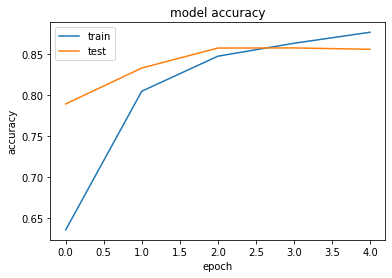

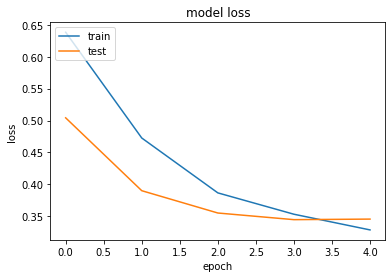

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Model 2
- LSTM and Convolutional Neural Network(CNN) For Sequence Classification
- Embedding Layer
- Add a one-dimensional CNN and max pooling layers
- Use a set of vector size features with a small filter length of 3 
- Use a standard length of 2 pooling layer to halve the feature map size

In [19]:
model_2 = Sequential()
model_2.add(Embedding(vocab_size, word2vec.vector_size, input_length=maxlen, weights=[embedding_matrix_word2vec]))
model_2.add(Conv1D(filters=word2vec.vector_size, kernel_size=3, padding='same', activation='relu'))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(Dropout(0.2))
model_2.add(LSTM(100))
model_2.add(Dropout(0.2))
model_2.add(Dense(1, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          19981500  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 300)          270300    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 300)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 300)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [20]:
history_2 = model_2.fit(X_train_padded_sequence, y_train, validation_data=(X_test_padded_sequence, y_test), 
                        epochs=5, batch_size=512, verbose=1)

/usr/local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 58s 2ms/step - loss: 0.5349 - accuracy: 0.7173 - val_loss: 0.3697 - val_accuracy: 0.8438
Epoch 2/5
25000/25000 [==============================] - 55s 2ms/step - loss: 0.3058 - accuracy: 0.8758 - val_loss: 0.3300 - val_accuracy: 0.8604
Epoch 3/5
25000/25000 [==============================] - 57s 2ms/step - loss: 0.2354 - accuracy: 0.9104 - val_loss: 0.3109 - val_accuracy: 0.8690
Epoch 4/5
25000/25000 [==============================] - 56s 2ms/step - loss: 0.2058 - accuracy: 0.9230 - val_loss: 0.3923 - val_accuracy: 0.8414
Epoch 5/5
25000/25000 [==============================] - 62s 2ms/step - loss: 0.1755 - accuracy: 0.9362 - val_loss: 0.3389 - val_accuracy: 0.8588


In [21]:
# final evaluation of the model
scores_2 = model_2.evaluate(X_test_padded_sequence, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

25000/25000 [==============================] - 17s 665us/step
Accuracy: 85.53%


In [22]:
print("Test Score:", scores_2[0])
print("Test Accuracy:", scores_2[1])

Test Score: 0.3388561863088608
Test Accuracy: 0.8587599992752075


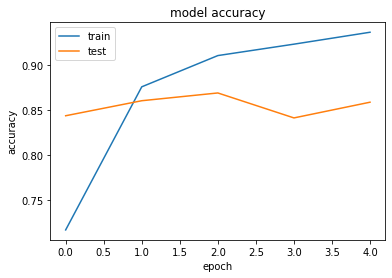

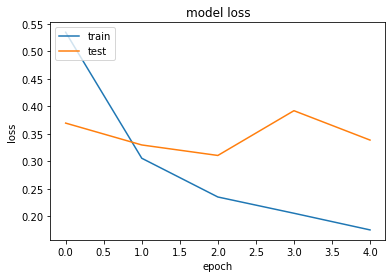

In [23]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Save the Model 1

In [25]:
import yaml
yaml_string = model.to_yaml()
with open('model/lstm.yml', 'w') as outfile:
    outfile.write(yaml.dump(yaml_string, default_flow_style=True))
model.save_weights('model/lstm.h5')